In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os
import numpy as np
import scipy
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import init, settings
import pudl.constants as pc
import pudl.extract.ferc1
import pudl.transform.ferc1
import pudl.output
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import gen_features

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

## Pull in the large FERC plants data and simplify it

In [2]:
ferc1_engine = pudl.extract.ferc1.connect_db()
ferc1_steam = pd.read_sql('SELECT * FROM f1_steam;', ferc1_engine)

In [18]:
# Vectorizing the DataFrame with a pre-processing function:
ferc1_steam_clean, fpv = pudl.transform.ferc1.vectorize_plants(ferc1_steam, ngram_range=(2,10))

In [19]:
[ (k,f.shape) for k,f in fpv.items() ]

[('plant_kind_clean', (11419, 7)),
 ('respondent_id', (11419, 135)),
 ('yr_const', (11419, 103)),
 ('row_number', (11419, 5)),
 ('spplmnt_num', (11419, 9)),
 ('tot_capacity', (11419, 1)),
 ('plant_name', (11419, 37512))]

In [20]:
# Vectorizing the DataFrame using sklearn_pandas
cat_feat_map = gen_features(
    columns=['plant_kind_clean', 'respondent_id', 'yr_const', 'row_number', 'spplmnt_num'],
    classes=[LabelBinarizer]
)
str_feat_map = [('plant_name', TfidfVectorizer(analyzer='char', ngram_range=(2,10)))]
num_feat_map = [(['tot_capacity'], MinMaxScaler())]
ferc_feat_map = cat_feat_map + str_feat_map + num_feat_map
ferc_mapper = DataFrameMapper(ferc_feat_map, sparse=True)
fmv = ferc_mapper.fit_transform(ferc1_steam_clean)

In [413]:
# Vectorizing the DataFrame using Transformer classes:
ferc_pipe = Pipeline([
    
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for vectorizing a FERC plant name using TF-IDF on character n-grams
            ('plant_name', Pipeline([
                ('selector', pudl.transform.ferc1.ColumnSelector(key='plant_name')),
                ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2,5))),
                ('norm', Normalizer())
            ])),

            ('respondent_id', Pipeline([
                ('selector', pudl.transform.ferc1.ColumnSelector(key='respondent_id')),
                ('lb', pudl.transform.ferc1.LabelBinarizerPipelineFriendly()),
                ('norm', Normalizer())
            ])),
            
            ('plant_kind', Pipeline([
                ('selector', pudl.transform.ferc1.ColumnSelector(key='plant_kind_clean')),
                ('lb', pudl.transform.ferc1.LabelBinarizerPipelineFriendly()),
                ('norm', Normalizer())
            ])),
            
            ('yr_const', Pipeline([
                ('selector', pudl.transform.ferc1.ColumnSelector(key='yr_const')),
                ('lb', pudl.transform.ferc1.LabelBinarizerPipelineFriendly()),
                ('norm', Normalizer())
            ])),
            
#            ('row_number', Pipeline([
#                ('selector', pudl.transform.ferc1.ColumnSelector(key='row_number')),
#                ('lb', pudl.transform.ferc1.LabelBinarizerPipelineFriendly()),
#                ('norm', Normalizer())
#            ])),

#            ('spplmnt_num', Pipeline([
#                ('selector', pudl.transform.ferc1.ColumnSelector(key='spplmnt_num')),
#                ('lb', pudl.transform.ferc1.LabelBinarizerPipelineFriendly()),
#                ('norm', Normalizer())
#            ])),

#            ('tot_capacity', Pipeline([
#                ('selector', pudl.transform.ferc1.pipelinize_feature(pudl.transform.ferc1.ColumnSelector(key='tot_capacity'))),
#                ('scaler', QuantileTransformer(output_distribution='normal')),
#                ('norm', Normalizer())
#            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'plant_name': 1.0,
            'respondent_id': 1.0,
            'plant_kind_clean': 1.0,
            'tot_capacity': 0.5,
            'yr_const': 0.5,
            'row_number': 0.2,
            'spplmnt_num': 0.2,
        },
    )), # end feature union
    
    ('clf', pudl.transform.ferc1.FERCPlantClassifier(min_sim=0.9, plants_df=ferc1_steam_clean))
    
]) # end pipeline

In [414]:
fpo = ferc_pipe.fit_transform(ferc1_steam_clean)

/home/zane/anaconda3/envs/pudl/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [415]:
plant_groups = fpo.predict(fpo.best_of_.record_id.values)
# Why do we get nothing back when there are any NaN values?

In [416]:
plant_group_sizes = pd.Series([len(g) for g in plant_groups])

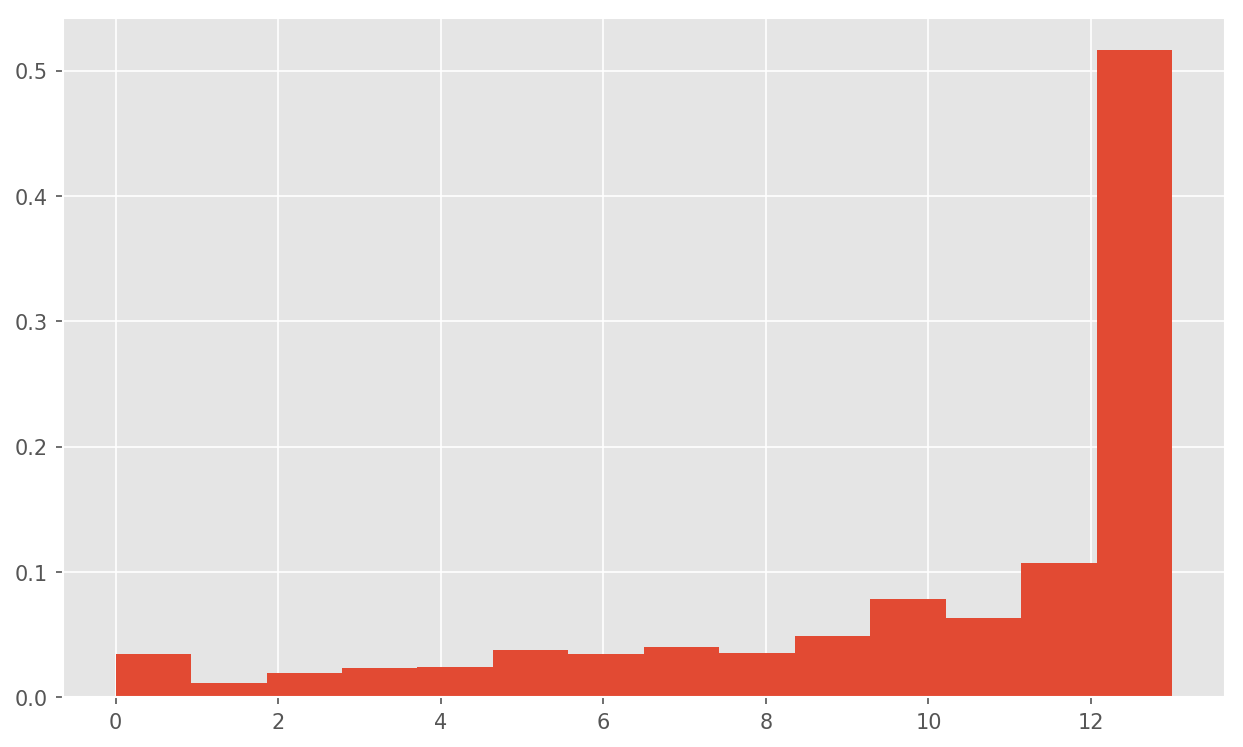

In [418]:
plt.hist(plant_group_sizes, bins=14, density=True, align='mid');

In [3]:
ferc1_steam = pd.read_sql('SELECT * FROM f1_steam;', ferc1_engine)

In [4]:
ferc1_steam.sample(10)

,respondent_id,report_year,spplmnt_num,row_number,row_seq,row_prvlg,plant_name,plant_kind,type_const,yr_const,yr_installed,tot_capacity,peak_demand,plant_hours,plnt_capability,when_not_limited,when_limited,avg_num_of_emp,net_generation,cost_land,cost_structure,cost_equipment,cost_of_plant_to,cost_per_kw,expns_operations,expns_fuel,expns_coolants,expns_steam,expns_steam_othr,expns_transfer,expns_electric,expns_misc_power,expns_rents,expns_allowances,expns_engnr,expns_structures,expns_boiler,expns_plants,expns_misc_steam,tot_prdctn_expns,expns_kwh,asset_retire_cost,report_prd
2514,54,2005,0,5,5,,,,,,,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,12
21593,194,2015,6,4,4,,,,,,,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,12
10885,87,2009,1,1,1,,Waterford 1 & 2,Steam,Full Outdoor,1975,1975,891.00,619.0,6946.0,0.0,822.0,816.0,41.0,5.471820e+08,2821239.0,18926296.0,162535878.0,184283413.0,206.8276,1599204.0,37480294.0,0.0,653043.0,0.0,0.0,754708.0,1405136.0,5313.0,354896.0,219799.0,258546.0,3298964.0,2353047.0,670588.0,49053538.0,0.0896,0.0,12
12322,85,2010,2,3,3,,Glenwood,Gas Turbine,Outdoor,1967,1972,126.00,86.0,166.0,0.0,115.0,105.0,0.0,1.946000e+06,0.0,128271.0,17702603.0,17830874.0,141.5149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12944.0,0.0,0.0,17091.0,0.0,0.0,13829.0,644414.0,688278.0,0.3537,0.0,12
7283,194,2007,2,4,4,,Edgewater Unit5(WPL),Steam,Conventional,1985,1985,285.00,312.0,0.0,314.0,0.0,0.0,0.0,1.821583e+09,-237369.0,34085718.0,212157763.0,246082848.0,863.4486,173462.0,36036789.0,0.0,1352758.0,169.0,0.0,676059.0,606867.0,0.0,0.0,172948.0,38065.0,1426025.0,200285.0,727617.0,41411044.0,0.0227,76736.0,12
1523,161,2004,0,2,2,,Four Corners,Steam,Semi-Outdoor,1969,1970,785.40,1556.0,8691.0,0.0,1490.0,0.0,169.0,5.150354e+09,0.0,16741572.0,471154698.0,488210667.0,621.6077,929030.0,69005740.0,0.0,5445454.0,0.0,0.0,700010.0,3135916.0,223267.0,0.0,563180.0,510577.0,11789796.0,3009038.0,3179431.0,98491439.0,0.0191,314397.0,12
5750,77,2007,3,1,1,,,,,,,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,12
1337,151,2004,0,1,1,,Ontario Station 13,Nuclear,Conventional,1970,1970,517.00,269.0,31700.0,0.0,0.0,0.0,0.0,1.917264e+09,0.0,0.0,0.0,0.0,0.0000,5730636.0,6283409.0,1038775.0,0.0,0.0,0.0,0.0,15755608.0,0.0,0.0,1810993.0,449827.0,6766668.0,2209134.0,356825.0,40401875.0,0.0211,0.0,12
6992,177,2007,1,3,3,,Kirksville C.T.,Gas Turbine,Peaking-Automatic,1967,1967,15.00,9.0,2.0,13.0,14.0,13.0,0.0,1.000000e+04,0.0,29930.0,1313383.0,1343313.0,89.5542,46836.0,2866.0,0.0,0.0,0.0,0.0,8850.0,10002.0,0.0,0.0,0.0,2510.0,0.0,19043.0,0.0,90107.0,9.0107,0.0,12
23226,41,2016,2,2,2,,Thetford,Gas Turbine Peaker,Conventional,1970,1971,222.06,0.0,0.0,0.0,0.0,0.0,0.0,-4.572400e+05,126315.0,687637.0,19981176.0,20795128.0,93.6464,13646.0,33953.0,0.0,0.0,0.0,0.0,72817.0,736.0,0.0,0.0,13646.0,2663.0,0.0,31037.0,0.0,168498.0,-0.3685,0.0,12


In [5]:
pudl_engine = pudl.init.connect_db()
ferc_depr = pd.read_sql('SELECT * FROM accumulated_depreciation_ferc1', pudl_engine)

In [6]:
ferc_depr.sample(10)

,respondent_id,report_year,line_id,total,electric_plant,future_plant,leased_plant
6266,95,2006,salvage_credit,4.100620e+05,4.100620e+05,0.0,0.0
33182,161,2015,other_debit_or_credit_items,-7.293415e+07,-7.293415e+07,0.0,0.0
16909,58,2009,transmission,1.721250e+07,1.721250e+07,0.0,0.0
26558,186,2013,total_net_charges_for_plant_retired,2.906773e+08,2.906773e+08,0.0,0.0
12215,141,2008,total_depreciation_provision_for_year,1.797139e+08,1.797139e+08,0.0,0.0
8129,428,2006,other_clearing_accounts,1.948800e+04,1.948800e+04,0.0,0.0
25557,309,2012,balance_end_of_year,1.729871e+09,1.729871e+09,0.0,0.0
10046,73,2007,depreciation_expense,1.442464e+08,1.442463e+08,111.0,0.0
31887,17,2014,other_accounts_specified,9.937690e+06,9.937690e+06,0.0,0.0
22993,153,2011,book_cost_of_plant_retired,6.883480e+05,6.883480e+05,0.0,0.0


In [7]:
ferc_purchased = pd.read_sql('SELECT * FROM purchased_power_ferc1', pudl_engine)

In [8]:
ferc_purchased.sample(10)

,id,respondent_id,report_year,authority_company_name,statistical_classification,rate_schedule_tariff_number,average_billing_demand,average_monthly_ncp_demand,average_monthly_cp_demand,mwh_purchased,mwh_received,mwh_delivered,demand_charges,energy_charges,other_charges,settlement_total
4311,4306,27,2005,J Aron & Company,OS,(2),None,None,None,15860630.0,0.0,0.0,1281240.0,603020840.0,0.0,604302080.0
12701,12688,133,2007,CONSTELLATION ENERGY,OS,6,N/A,N/A,N/A,210080.0,0.0,0.0,0.0,12107316.0,0.0,12107316.0
1325,1322,127,2004,East KY Power Co-Op Power Mktg,OS,(1),None,None,None,15.0,0.0,0.0,0.0,1495.0,0.0,1495.0
45796,45797,45,2016,BOYD LEON HYDER,LU,(1),None,None,None,12.0,0.0,0.0,0.0,581.0,0.0,581.0
44449,44450,7,2016,PacifiCorp Exchange,EX,182,N/A,N/A,N/A,0.0,570837.0,568702.0,0.0,1060859.0,0.0,1060859.0
24373,24348,190,2010,"Select Energy, Inc.",OS,SE 6,None,None,None,32274.0,0.0,0.0,0.0,1451601.0,316237.0,1767838.0
19129,19109,281,2008,Flying Cloud Power Partners,LU,NA,None,None,None,146101.0,0.0,0.0,0.0,3542097.0,0.0,3542097.0
16707,16686,187,2008,BP Energy Comp,SF,WSPP,None,None,None,23768.0,0.0,0.0,0.0,1448158.0,0.0,1448158.0
42851,42851,147,2015,"WRGS_Westar Energy, Inc.",SF,U,None,None,None,1897.0,0.0,0.0,0.0,54847.0,0.0,54847.0
23280,23257,80,2010,Cobb Electric Membership Corporation,OS,(1),None,None,None,41.0,0.0,0.0,0.0,2032.0,0.0,2032.0


In [9]:
epacems_hourly = pd.read_sql('SELECT * FROM hourly_emissions_epacems', pudl_engine)

In [10]:
epacems_hourly.sample(10)

ValueError: a must be greater than 0